In [ ]:
from google.colab import drive
drive.mount('/content/drive') #connect your drive to notebook

In [ ]:
pip install jpype1

In [ ]:
import jpype
from jpype import JClass, JString, getDefaultJVMPath, shutdownJVM, startJVM, java
import nltk
from nltk.corpus import stopwords
from string import punctuation, digits
import itertools
from pathlib import Path
from typing import List
from collections import Counter
from pathlib import Path
import numpy as np
import pandas as pd
import re
import os
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
nltk.download("all")

# <font color='blue'>Read the Data Set</font>

In [ ]:
%%time
# Making sure Turkish characters appear correctly.
df = pd.read_csv("drive/My Drive/Veri Setleri/CC_DuyguAnalizi.csv", delimiter = "~", encoding='latin-1')
replaceDict={'Ý':'İ','Ð':'Ğ','Þ':'Ş','þ':'ş','ý':'ı','ð':'ğ'}

for x in replaceDict:
    df=df.replace(x,replaceDict[x],regex=True)
    
df.head()

In [ ]:
df["TICKET_DESC"]=df["TICKET_DESC"].astype(str)

# <font color='red'> Step 1: Cleaning the Data </font>

Our data set, which contains millions of messages sent by Istanbul residents to the Municipality's Call Center, is very dirty. The following section will outline the cleaning process.

## <font color='blue'> Replacing Emoticons; Removing Links, Digits, and Punctuation; Turning all Letters into Lowercase </font>

In [ ]:
def replaceemoticon(word):
    
    pos = re.findall(r"(?::\) | :-\) | =\) | :D | :d | <3 | \(: | :\'\) | \^\^|;\) | \(-:)", word)
    neg = re.findall(r"(:-\( | :\( | ;\( | ;-\( | =\( | :/ | :\\ | -_- | \): | \)-:)", word)
  
    if pos:
        #if = ":)"
        word = word + " pozitif"

    elif neg:
        #if = ":("
        word = word + " negatif"

    return word

In [ ]:
df["preProcessing"] = df["TICKET_DESC"].map(replaceemoticon)

In [ ]:
def preProcessing(text):

  return resubsatır(df_remove_punc(df_remove_digits(unlem(df_remove_email_adressed(df_remove_com_tr(df_remove_link(text)))))))

def df_remove_link(text):
  return re.sub(r"((http\S+)|(www\S+))", " ", text)

def df_remove_com_tr(text):
    text = re.sub(r'\S*\.(com|tr)'," ",text)
    return text

def df_remove_email_adressed(text):
  return re.sub(r'([.\w]{3,}@[.\w]{5,})', ' ', text)

def df_remove_digits(text): #remove 0123456789
    text=text.strip()
    remove_digits = str.maketrans(' ', ' ', digits)
    return text.translate(remove_digits)

def unlem(text): # '!' denotes strong feelings. Thus, we don't want to remove it. We will keep it in word format, as "unlem" ("exclamation mark" in Turkish).
    if "!" in text:
      return text + " ünlem"
    else:
      return text

def resubsatır(text): #remove \n 
    texts= re.sub("\n"," ",text)
    return texts

def df_remove_punc(text): #remove punctuation
    regex = re.compile('[%s]' % re.escape(punctuation))
    return regex.sub(' ', text)

In [ ]:
%%time

# Remove http, com, link, digits:

df["preProcessing"] = df["preProcessing"].map(preProcessing)

In [ ]:
def replace_a(text):
    if "â" in text:
      return text+"a"
    else:
      return text

In [ ]:
%%time

df["preProcessing"] = df["preProcessing"].map(replace_a)

In [ ]:
def lowers(text):
    text=re.sub("İ","i",text)
    text = text.lower()
    return text

df["preProcessing"] = df["preProcessing"].map(lowers)

## <font color='blue'> Deleting Reply Tickets Written by Call Center Officers </font>

In [ ]:
data=df.copy()

In [ ]:
pd.set_option("display.max_rows", data.shape[0])
pd.set_option('display.max_colwidth', data.shape[0])

In [ ]:
# Drop all duplicates in the TICKET_DESC column.

data.drop_duplicates(subset=['preProcessing'], inplace = True)

In [ ]:
# Drop the NA data.

data.dropna(subset = ["preProcessing"], inplace = True)

In [ ]:
data.shape

(1296505, 8)

In [ ]:
# Trying different combinations to target response tickets written by Instanbul Metropolitan Municipality call center officers:

data = data[~data.preProcessing.str.contains(" bilgi verildi")]
data = data[~data.preProcessing.str.contains(" bilgi verildi.")]
data = data[~data.preProcessing.str.contains("bilgi verildi")]
data = data[~data.preProcessing.str.contains("bilgi verildi.")]
data = data[~data.preProcessing.str.contains("bilgi veirldi")]
data = data[~data.preProcessing.str.contains("bilgi veirldi.")]
data = data[~data.preProcessing.str.contains("bv")]
data = data[~data.preProcessing.str.contains("b.v")]
data = data[~data.preProcessing.str.contains("b.v.")]
bilgi =  (r"(\s*)b.?lg.?s?.?(\s*)?v.?r.?l(d.?|m.?.?t.?r).?")  
bilgi_kısa =(r".?b.?v.?")
nolu_basvuru = (r".?n.?l.?(\s*)?b.?(s|ş)v.?r.?")         
numaralı_basvuru = (r".?n.?m.?r.?l.?(\s*)?b.?(s|ş)v.?r.?")
data = data[~data.preProcessing.str.contains(bilgi)]
data = data[~data.preProcessing.str.contains(bilgi_kısa)]
data = data[~data.preProcessing.str.contains(nolu_basvuru)]
data = data[~data.preProcessing.str.contains(numaralı_basvuru)]
tespit = (r".?t.?sp.?t(\s*)?.?d.?l(d.?|m.?.?t.?r).?") 
data = data[~data.preProcessing.str.contains(tespit)]
kayıt =  (r".?k.?y.?t(\s*)?.?l.?na?(m.?)?(d.?|m.?.?t.?r).?") 
kayıt2 =  (r".?k.?y.?t(\s*)?.?(c|ç).?la?(m.?)?(d.?|m.?.?t.?r).?")
data = data[~data.preProcessing.str.contains(kayıt)]
data = data[~data.preProcessing.str.contains(kayıt2)] 
talep =  (r"t.?.?p(\s*)?.?l.?na?(m.?)?(d.?|m.?.?t.?r).?") 
talep2 =  (r"t.?l.?p(\s*)?.?l.?(s|ş)t.?r.?la?(m.?)?(d.?|m.?.?t.?r).?") 
data = data[~data.preProcessing.str.contains(talep)]
data = data[~data.preProcessing.str.contains(talep2)] 

# Approx. ~25.000 tickets

## <font color='blue'> Deleting Outlier Tickets (Too Short or Too Long) </font>

In [ ]:
# Adding a new column which denotes word count.

data['totalwords'] = data['preProcessing'].str.split().str.len()

In [ ]:
# The min and max word limits were determined by totalwords min - max values and standard deviation.

data = data[data.totalwords > 6]
data = data[data.totalwords < 61]

In [ ]:
data.shape

## <font color='blue'> Tokenizing Words </font>

In [ ]:
nltk.download('punkt')
from nltk.tokenize import word_tokenize, sent_tokenize

In [ ]:
data['preProcessing'] = data.apply(lambda row: word_tokenize(row['preProcessing']), axis=1)

In [ ]:
# We change the data type to string:

def tokenize_to_str(text):
  text= re.sub(r"'","", text)
  text= re.sub(r",","", text)
  text= re.sub(r"\[","", text)
  text= re.sub(r"\]","", text)
  return text

In [ ]:
def tokenizeList_to_str(text):
  return " ".join(text)

In [ ]:
data['preProcessing'] = data['preProcessing'].map(tokenizeList_to_str)

## <font color='blue'> Deleting Unknown Characters </font>

In [ ]:
karakterler=[]
def find(text):
  for i in text:
    if(i not in ["q","x","w","a","b","c","ç","d","e","f","g","ğ","h","ı","i","j","k","l","m","n","o","ö","p","r","s","ş","t","u","ü","v","y","z"]):
      karakterler.append(i) #known characters 
    else:
      continue
data["preProcessing"].map(find)

In [ ]:
silinecek_unique = set(karakterler) #unknown characters
print(silinecek_unique)

{'²', 'ê', '©', 'ó', '³', 'ò', '´', 'ù', 'õ', '«', '¿', 'ß', 'û', '\x91', 'ä', 'ï', '»', 'â', 'í', '¨', '÷', 'æ', 'å', 'é', 'ø', '×', 'ô', '°', '¶', 'ú', '¾', '\x7f', '£', 'ì', 'á', '¸', '¹', '·', '¼', 'î', 'ñ', 'ë', 'è', 'à', '±', '§', '½', ' ', '\x92', 'ã'}


In [ ]:
silinecek_unique = set(karakterler)
for i in silinecek_unique:
  data["preProcessing"]=data["preProcessing"].str.replace(i," ")

In [ ]:
data.iloc[4000:4010]

## <font color='blue'> Deleting Single-Letter Words</font>

In [ ]:
#After the deleting digits aspecially one letter words are appeared in the datasetet 
# We are deleting one charactered words not two, because there are some important words in Turkish which have 2 letters in it : ev/ol/su/ay 
def sil_1(text):
    text_list=text.split()
    for i in text_list:
        if len(i)==1:
            text_list.remove(i)   
    return " ".join(text_list)

In [ ]:
data["preProcessing"]=data["preProcessing"].map(sil_1)

## <font color='blue'> Deleting Stopwords </font>

In [ ]:
WPT = nltk.WordPunctTokenizer()
stop_word_list = nltk.corpus.stopwords.words('turkish')
stop_word_list.remove('ama') #except "ama" because it has important negativity meaning in the sentence

In [ ]:
def stopwords_sil(text):
    text_list=text.split()
    silinmis_list = [text for text in text_list if text not in stop_word_list]
    silinmis_list=" ".join(silinmis_list)
    ##print(silinmis_list)
    return silinmis_list

In [ ]:
data["preProcessing"]=data["preProcessing"].map(stopwords_sil)

## <font color='blue'> Deleting English Tickets </font>

In [ ]:
pip install fasttext

In [ ]:
import fasttext
PRETRAINED_MODEL_PATH = 'drive/MyDrive/NLP/Kutuphaneler, Kaynaklar/lid.176.bin'
model = fasttext.load_model(PRETRAINED_MODEL_PATH)

In [ ]:
def ing(text):
    predictions = model.predict([text], k=2) #it will give you the most possible two languge label
    if predictions[0][0][0] =="__label__tr":
        y=predictions[1][0][0]
        if y > 0.92: #0.92 determined by the several English ticket examples in our dataset content 
            return "tr" #this will labelled the rows as "tr" or "NaN" according to their lang score

In [ ]:
data["lang"]=data["preProcessing"].map(ing)

In [ ]:
data.shape

(831724, 10)

In [ ]:
tr_olmayan_df=data[data["lang"]!="tr"] ## how many rows are not Turkish?
tr_olmayan_df.shape

(26274, 10)

In [ ]:
data_ingsiz=data.dropna(subset=['lang']) #deleting NaN valued,which in Lang column, rows

In [ ]:
data_ingsiz.shape

(805450, 10)

In [ ]:
#checking if the code works for deleting English texts

filt=data["TICKET_DESC"].str.contains("thank", na=False )
data_ingsiz.loc[filt, ["TICKET_DESC","ORG_TICKET_ID", "preProcessing","lang"]]

In [ ]:
#checking if the code works for deleting English texts

filt=data_ingsiz["TICKET_DESC"].str.contains("To whom it may concern,\nI would like to ask where I can buy the Istanbul Mavi Kart, thank you\n\nBest regards,\n\nİlgili makama,\nİstanbul Mavi Kart'ı nereden alabilirim diye sormak istiyorum, teşekkür ederim", na=False )
data_ingsiz.loc[filt, ["TICKET_DESC","ORG_TICKET_ID", "preProcessing","lang"]]

In [ ]:
data_ingsiz.to_csv(r'drive/My Drive/..yourpath../PreProcessing_pt1.csv', index=False) 

In [ ]:
data_ingsiz.shape

(805450, 10)

# <font color='red'> Step 2: Sampling </font>

Our data is very big, with almost a million of rows. Considering the time and resources needed to analyze such big data, we decided to proceed with the process by drawing a random sample from our data.

In [ ]:
dataP = pd.read_csv(r'drive/My Drive/..yourpath../PreProcessing_pt1.csv') #reading data_ingsiz dataframe

In [ ]:
dataP['X_IBB_COUNTY'].value_counts().to_frame() #check all Counties

In [ ]:
dataP['X_IBB_COUNTY'].value_counts().index.tolist()

In [ ]:
# 39 Counties in İstanbul
ist_ilce = ['ADALAR', 'ARNAVUTKÖY', 'ATAŞEHİR', 'AVCILAR', 'BAĞCILAR', 'BAHÇELİEVLER', 'BAKIRKÖY', 'BAŞAKŞEHİR', 'BAYRAMPAŞA', 'BEŞİKTAŞ', 'BEYKOZ', 'BEYLİKDÜZÜ', 'BEYOĞLU', 'BÜYÜKÇEKMECE', 'ÇATALCA', 'ÇEKMEKÖY', 'ESENLER', 'ESENYURT', 'EYÜPSULTAN', 'FATİH', 'GAZİOSMANPAŞA', 'GÜNGÖREN', 'KADIKÖY', 'KAĞITHANE', 'KARTAL', 'KÜÇÜKÇEKMECE', 'MALTEPE', 'PENDİK', 'SANCAKTEPE', 'SARIYER', 'ŞİŞLİ', 'ŞİLE', 'SİLİVRİ', 'SULTANBEYLİ', 'SULTANGAZİ', 'TUZLA', 'ÜMRANİYE', 'ÜSKÜDAR', 'ZEYTİNBURNU']

In [ ]:
len(ist_ilce)

39

In [ ]:
df2 = dataP[dataP['X_IBB_COUNTY'].isin(ist_ilce)] 

# We noticed that the data contains counties oustide of Istanbul.
# We will remove them, as we are only interested in conducting Istanbul's sentiment analysis.

Before sampling, we separate all positive tickets, as they are relatively fewer. Thus, we extract all "TEŞEKKÜRLER" SR_AREA rows from the dataset because we plan to add those at the end.

In [ ]:
df2.drop(df2[df2.SR_AREA != "TEŞEKKÜRLER"].index, inplace = True)

In [ ]:
df2.shape


(2796, 10)

In [ ]:
df2.to_csv(r'drive/My Drive/Veri Setleri/pozitif.csv', index=False) 

We continue with sampling.

In [ ]:
dataP=dataP[dataP['X_IBB_COUNTY'].isin(ist_ilce)] 

In [ ]:
A=dataP['X_IBB_COUNTY'].value_counts() # All 39 counties can be counted with their ticket amounts.

In [ ]:
print(A)

In [ ]:
df_i = dataP.set_index("ORG_TICKET_ID") # Making uniq ticket ids as indexes because we will sample the dataset by those ids.

In [ ]:
b= dataP.shape[0]/ 200000 # We will sample out the 200.000 tickets from dataP row counts.
print(b) # Sample ratio

In [ ]:
def ayrıdf(i):
  filter=(dataP['X_IBB_COUNTY'].str.contains(i, na=False) & (dataP["SR_AREA"]!="TEŞEKKÜRLER") ) # Filtering the dataframe for each county
  df3=dataP.loc[filter]
  aa=pd.DataFrame(df3) # County specific dataframe
  count=int(int(A.loc[i])/b) # County specific sample size
  sampled=aa["ORG_TICKET_ID"].sample(n= count) # Sampling
  df_pre= df_i.loc[sampled] 
  df_pre.reset_index(inplace=True)
  return  df_pre.to_csv(r'drive/My Drive/Veri Setleri/county_sample/{0}.csv'.format(i), index=False)

In [ ]:
for i in ist_ilce:
  ayrıdf(i)

## <font color='blue'> Merging Into One Dataset </font>

https://www.freecodecamp.org/news/how-to-combine-multiple-csv-files-with-8-lines-of-code-265183e0854/

In [ ]:
os.chdir("drive/My Drive/Veri Setleri/yeşim/totalsample") 

In [ ]:
extension = 'csv'
all_filenames = [i for i in glob.glob('*.{}'.format(extension))]

In [ ]:
# Combine all files in the list.

combined_csv = pd.concat([pd.read_csv(f) for f in all_filenames ])

# Export to csv.

combined_csv.to_csv( "combined.csv", index=False, encoding='utf-8-sig')

In [ ]:
comb=pd.read_csv("combined.csv") 

In [ ]:
comb['X_IBB_COUNTY'].value_counts() # Check

In [ ]:
comb_pos = pd.concat([comb, df2 ]) # Combine 200.000 tickets with positive tickets extracted before. 

# <font color='red'> Step 3: Correcting Mispelled Words </font>

In [ ]:
import jpype
from jpype import getDefaultJVMPath,JClass
jar = r"drive/MyDrive/NLP/Kutuphaneler, Kaynaklar/zemberek-full.jar" 
from jpype import getDefaultJVMPath,JClass
if not jpype.isJVMStarted():
    jpype.startJVM(getDefaultJVMPath(), classpath=[jar])

In [ ]:
#downloading packages from zemberek framework
ZEMBEREK_PATH = r'drive/MyDrive/NLP/Kutuphaneler, Kaynaklar/zemberek-full.jar'
TurkishMorphology = JClass('zemberek.morphology.TurkishMorphology')
TurkishSpellChecker = JClass('zemberek.normalization.TurkishSpellChecker')
TurkishSentenceNormalizer = JClass('zemberek.normalization.TurkishSentenceNormalizer')
Paths = JClass('java.nio.file.Paths')
lookupRoot = Paths.get("drive/MyDrive/NLP/Kutuphaneler, Kaynaklar/normalization")
lmPath = Paths.get("drive/MyDrive/NLP/Kutuphaneler, Kaynaklar/data/lm/lm.2gram.slm")
morphology = TurkishMorphology.createWithDefaults()
morph = TurkishMorphology.createWithDefaults()
spell = TurkishSpellChecker(morph)

In [ ]:
WPT = nltk.WordPunctTokenizer()
stop_word_list = nltk.corpus.stopwords.words('turkish')
stop_word_list.remove('ama')
WORDS = dict()
spell_folder = Path(r"drive/MyDrive/NLP/Kutuphaneler, Kaynaklar")
def words(text): return re.findall(r'\w+', text.lower())
with open(os.path.expanduser(Path(spell_folder/ "big2_yesim.txt")), "r", encoding = 'utf-8') as f: 
#big2_yesim.txt is a folder which contains word dictionary , also some words are added special to our dataset such as "Covid"
    for line in f:
        splitted = line.split()
        WORDS[splitted[0]] = int(splitted[1])

In [ ]:
def reverse(s): 
    if len(s) == 0: 
        return s 
    else: 
        return reverse(s[1:]) + s[0] 

def checkOpennes(word):
    vowels=['a','e','i','ı','o','ö','u','ü']
    open_vowels=['e','i','ü','ö']
    close_vowels=['a','ı','o','u']
    for i in range(len(word)):
        if reverse(word)[i] in vowels:
            if reverse(word)[i] in open_vowels:
                return True
            else:
                return False
        else:
            continue
def PresentCheck(word):
        ei=['e','i']
        aı=['a','ı']
        üö=['ü','ö']
        uo=['u','o']
        for i in range(len(word)):
            if reverse(word)[i] in ei:
                return 'ei'
            elif reverse(word)[i] in üö:
                return 'üö'
            elif reverse(word)[i] in aı:
                return 'aı'
            elif reverse(word)[i] in uo:
                return 'uo'
            else:
                continue
    
def StartCheck(word):
        ei=['e','i']
        aı=['a','ı']
        üö=['ü','ö']
        uo=['u','o']
        for i in range(len(word)):
            if (word)[i] in ei:
                return 'ei'
            elif (word)[i] in üö:
                return 'üö'
            elif (word)[i] in aı:
                return 'aı'
            elif (word)[i] in uo:
                return 'uo'
            else:
                continue
def replaceall(s, n,a):
    occurence = s.count(n)
    alt = []
    temp = s
    for i in range(occurence):
        temp2 = temp
        for j in range(i,occurence):
            temp2 = temp2.replace(n,a,1)
            alt.append(temp2)
        temp = temp.replace(n,"!",1)
    for i in range(len(alt)):
        alt[i] = alt[i].replace("!",n)

    return alt

def P(word, N=sum(WORDS.values())):
    "Probability of `word`."
    if  word in WORDS.keys():
        number = WORDS[word]
    else:
        number = 1
    if number == 0:
        number = 1
    return number / N

def correction(word):
      return max(candi(word), key=P)

def candi(word):
    "Generate possible spelling corrections for word."
    return (known([word]) or known(edits1(word)) or known(edits2(word)) or [word])

def known(words):
    "The subset of `words` that appear in the dictionary of WORDS."
    return set(w for w in words if w in WORDS)

def edits1(word):
    "All edits that are one edit away from `word`."
    letters    = 'abcçdefgğhıijklmnoöprsştuüvyzw'
    splits     = [(word[:i], word[i:])    for i in range(len(word) + 1)]
    deletes    = [L + R[1:]               for L, R in splits if R]
    transposes = [L + R[1] + R[0] + R[2:] for L, R in splits if len(R)>1]
    replaces   = [L + c + R[1:]           for L, R in splits if R for c in letters]
    inserts    = [L + c + R               for L, R in splits for c in letters]
 
    sp     = replaceall(word,'ı','i')
    sp2     = replaceall(word,'u','ü')
    sp3    = replaceall(word,'o','ö')
    sp4     = replaceall(word,'g','ğ')
    sp5     = replaceall(word,'c','ç')
    sp6     = replaceall(word,'s','ş')
    sp7     = replaceall(word,'i','ı')
    sp8     = replaceall(word,'ö','o')
    sp9     = replaceall(word,'ş','s')
    sp10     = replaceall(word,'ğ','g')
    sp11     = replaceall(word,'ç','c')
    sp12     = replaceall(word,'ü','u')
    specials=[]
    specials.extend(sp)
    specials.extend(sp2)
    specials.extend(sp3)
    specials.extend(sp4)
    specials.extend(sp5)
    specials.extend(sp6)
    specials.extend(sp7)
    specials.extend(sp8)
    specials.extend(sp9)
    specials.extend(sp10)
    specials.extend(sp11)
    specials.extend(sp12)
    return set(deletes+transposes+replaces+inserts+specials)

def edits2(word):
    "All edits that are two edits away from `word`."
    return (e2 for e1 in edits1(word) for e2 in edits1(e1))
def print_diff(word, s):
    if not word == s:
        print(word + " --> " + s)
counter = 0


def lemmatizer(word,texts):
        wordList=[]
        wordList = re.sub("[^\w]", " ",  texts).split()
       
        pos=wordList.index(word)
     
        sakin=''
        word=correction(word)
        
        if len(wordList)-pos>3 and pos>2:
            for i, kelime in enumerate(wordList[pos-3:pos+4]):
                sakin=sakin+correction(kelime)+' '
        elif pos<=2 and len(wordList)-pos>5:
            for i, kelime in enumerate(wordList[pos:pos+5]):
                sakin=sakin+correction(kelime)+' '
        elif pos<=2 and len(wordList)-pos<=5:
            for i, kelime in enumerate(wordList[pos:len(wordList)]):
                sakin=sakin+correction(kelime)+' '
        elif len(wordList)-pos<1 and pos>3:
            for i, kelime in enumerate(wordList[pos-3:len(wordList)]):
                sakin=sakin+correction(kelime)+' '
        elif len(wordList)<3:
            for i, kelime in enumerate(wordList):
                sakin=sakin+correction(kelime)+' '
        else:
             for i, kelime in enumerate(wordList):
                sakin=sakin+correction(kelime)+' '
        results = morphology.analyze(word)
        lemma=[]
        form=[]
        l=[]
        m=[]
        for i, result in enumerate(results):
            form.append(str(result.formatLong()))
            lemma.append(result.getLemmas()[0])
        if len(lemma)>1:
                analysis = morphology.analyzeSentence(sakin)
                results = morphology.disambiguate(sakin, analysis).bestAnalysis()
                for i, result in enumerate(results):
                        l.append(result.getLemmas()[0])
                        m.append(result.formatLong())
                for i in range(len(m)):
                    for j in range(len(form)):
                        if m[i]==form[j]:
                            lema=lemma[j]
                            if lema=='değil':
                                return 'değil'
                            if 'Neg' in form[j] or 'WithoutHavingDoneSo' in form[j] or 'Unable' in form[j]:
                                if checkOpennes(word):
                                    return lema+'me'
                                else:
                                    return lema+'ma'
                            if 'Without' in form[j]:
                                if PresentCheck(word)=='ei':
                                    return lema+'siz'
                                elif PresentCheck(word)=='aı':
                                    return lema+'sız'
                                elif PresentCheck(word)=='uo':
                                    return lema+'suz'
                                else:
                                    return lema+'süz'
                            if 'With' in form[j]:
                                if PresentCheck(word)=='ei':
                                    return lema+'li'
                                elif PresentCheck(word)=='aı':
                                    return lema+'lı'
                                elif PresentCheck(word)=='uo':
                                    return lema+'lu'
                                else:
                                    return lema+'lü'
                            else:
                                return lema
                    else:
                        continue
        elif len(lemma)==1:
            if lemma[0]=='değil':
                return lemma[0]
            if 'Neg' in form[0] or 'WithoutHavingDoneSo' in form[0] or 'Unable' in form[0]:
                 if checkOpennes(word):
                    return lemma[0]+'me'
                 else:
                    return lemma[0]+'ma'
            elif 'Without' in form[0]:
                if PresentCheck(word)=='ei':
                    return lemma[0]+'siz'
                elif PresentCheck(word)=='aı':
                    return lemma[0]+'sız'
                elif PresentCheck(word)=='uo':
                    return lemma[0]+'suz'
                else:
                    return lemma[0]+'süz'
            elif 'With' in form[0]:
                if PresentCheck(word)=='ei':
                    return lemma[0]+'li'
                elif PresentCheck(word)=='aı':
                    return lemma[0]+'lı'
                elif PresentCheck(word)=='uo':
                    return lemma[0]+'lu'
                else:
                    return lemma[0]+'lü'
            else:
                return lemma[0]
        else:
            return word




In [ ]:
# To shorten the process time we created a dictionary from the previous corrected words by the lemmatizer function.
# If a word is corrected previously, it will skip the above functions and is directly replaced with the corrected version from the dictionary.

import json
f = open(r"drive/MyDrive/NLP/Kutuphaneler, Kaynaklar/clean optimizasyon/bizim_sozluk.json", "r")
str_sozluk=f.read()
str_sozluk=str_sozluk.replace("\'", "\"")
bizim_sozluk = json.loads(str_sozluk)

In [ ]:
def clean(text):
    text_list=text.split()
    for i, word in enumerate(text_list):
        if (word in bizim_sozluk):
          text_list[i] =bizim_sozluk[word]
        else:
          text_list[i] = lemmatizer(word,text)
          bizim_sozluk[word]= text_list[i]
    return ' '.join(''.join(elems) for elems in text_list)

In [ ]:
comb_pos["clean_new"]=comb_pos["preProcessing"].map(clean)

# df["clean"].iloc[0:2000]=df["preProcessing"].iloc[0:2000].map(clean) --> You can work the code with row batches

In [ ]:
## Updating the dictionary in each row batches.
# Will shorten the other -comb_pos["clean"]=comb_pos["preProcessing"].map(clean)- cycle time

with open(r'drive/MyDrive/NLP/Kutuphaneler, Kaynaklar/clean optimizasyon/bizim_sozluk.json', 'w') as f:
    print(bizim_sozluk, file=f)
f = open(r"drive/MyDrive/NLP/Kutuphaneler, Kaynaklar/clean optimizasyon/bizim_sozluk.json", "r")
str_sozluk=f.read()
str_sozluk=str_sozluk.replace("\'", "\"")
bizim_sozluk = json.loads(str_sozluk)

In [ ]:
comb_pos.to_csv(r'drive/My Drive/Veri Setleri/ETİKETLENENLER/SON/final_data-tagpozclean.csv', index=False) 

## <font color='blue'> Name-Entity Recognition </font>

In [ ]:
s1=comb_pos["clean_new"]
s2=[word for sentences in s1 for word in sentences.split()]
len(set(s2)) #uniq word counts to compare our last point to the start point

In [ ]:
!pip install transformers

In [ ]:
from transformers import pipeline, AutoModelForTokenClassification, AutoTokenizer
model = AutoModelForTokenClassification.from_pretrained("savasy/bert-base-turkish-ner-cased")
tokenizer = AutoTokenizer.from_pretrained("savasy/bert-base-turkish-ner-cased")
ner_model=pipeline('ner', model=model, tokenizer=tokenizer)
# using transfer learning in this phase : BERT NER Model

In [ ]:
silinmeyecekler=["arı","peron","durak","ring","roger","rogar","sivrisinek","sivri","karasinek"]
silinmeyecekler=set(silinmeyecekler) 
## Those words are determined in the labelling phase as important. 
# That's why those words won't be deleted by NER code.

In [ ]:
def ner_bul(text): 
  kelime_dizisi=text.split()
  son_hal=""
  for i in kelime_dizisi:
    if (i in silinmeyecekler):
      son_hal+=" "+i
    else:
      result=ner_model(i)
      if (result!=[]):
        if (result[0]["score"]>=0.94): #0.94 limit is determined by reviewing NER results on our final dataset.
          continue
        else:
          son_hal+=" "+i
      else:
        son_hal+=" "+i
  return son_hal

In [ ]:
df["clean_ner"]=df["clean_new"].map(ner_bul)

In [ ]:
#checking unique word count after deleting name entities
s1=comb_pos["clean_ner"]
s2=[word for sentences in s1 for word in sentences.split()]
len(set(s2))

## <font color='blue'> Deleting Names </font>

In [ ]:
path="drive/MyDrive/NLP/son_rötuş"

In [ ]:
f = open(r"{0}/isimler".format(path), "r") # "isimler" file contains person name list
isim=f.read()
print(f.read()) 

In [ ]:
isim=isim.replace("\n", " ") 
isim_listesi=isim.split(" ")
isim_listesi #make ready the person name file as a list

In [ ]:
set_isim_list=set(isim_listesi)

In [ ]:
isimler=[]
for i in set_isim_list:
  isimler.append(i.lower())

In [ ]:
def isim_sil(text):
  texts=text.split()
  sonhal=""
  for i in texts:
    if (i in isimler):
      ##delete
      continue
    else:
      ##don't delete
      sonhal+=" "+i
  return sonhal

In [ ]:
comb_pos["clean_ner"]=comb_pos["clean_ner"].map(isim_sil)

In [ ]:
# unique words after cleaning the person names from the dataframe
s1=comb_pos["clean_ner"]
s2=[word for sentences in s1 for word in sentences.split()]
len(set(s2))

## <font color='blue'> Splitting Unseparated Words </font>

In [ ]:
import json
f = open(r"{0}/bizim_sozluk.json".format(path), "r") 
zemb_dict=f.read()
zemb_dict=zemb_dict.replace("\'", "\"")
zemb_dict = json.loads(zemb_dict) 
# the dictionary that is occur in Cleaning chapter from the corrected words

In [ ]:
zemb_dict={ k:v  for k,v in zemb_dict.items() if (k!=v) }
len(zemb_dict)

In [ ]:
import json
f = open(r"{0}/master.txt".format(path), "r")
dictionary=f.read()
dictionary = dictionary.strip('][').split(', ') 
for i in range(len(dictionary)):
    dictionary[i]=dictionary[i].replace("\'", "") # another open source word dictionary added into the process to help splitting code

In [ ]:
dictionary=[i.replace('"',"") for i in dictionary]
len(dictionary)

In [ ]:
# latest unique word counting
s1=comb_pos["clean_ner"]
s2=[word for sentences in s1 for word in sentences.split()]
len(set(s2)) 

In [ ]:
notInDict=set(words)-set(dictionary)

In [ ]:
dictionary=set(dictionary)

In [ ]:
def splitword(word):

    for x in range(3,len(word)-2): ## sağlıkduyar -> sağlık duyar
        if (word[0:x] in dictionary and word[x:len(word)] in dictionary): 
            return word[0:x]+" "+word[x:len(word)]
    for x in range(3,len(word)-2):  ## duyarsağlik -> duyar sağlık
        if (word[0:x] in dictionary and word[x:len(word)] not in dictionary):
          if ( word[x:len(word)] in zemb_dict):
            return word[0:x]+" "+zemb_dict[word[x:len(word)]]
    for x in range(3,len(word)-2):  ##ssağlikduyar -> sağlık duyar
        if (word[0:x] not in dictionary and word[x:len(word)]  in dictionary):
          if ( word[0:x] in zemb_dict):
            return zemb_dict[word[0:x]]+" "+word[x:len(word)]
    ## checking the zemb_dict
    for x in range(3,len(word)-2): ### sağlikbenım -> sağlık ben
        if (word[0:x]  in zemb_dict and word[x:len(word)]  in zemb_dict):
          return zemb_dict[word[0:x]]+" "+zemb_dict[word[x:len(word)]]
    for x in range(3,len(word)-2): ### sağlikbenımm -> sağlık benımm
        if (word[0:x]  in zemb_dict and word[x:len(word)] not in zemb_dict):
          return zemb_dict[word[0:x]]+" "+word[x:len(word)]
    for x in range(3,len(word)-2): ### benımsağlik -> benımm sağlık
        if (word[0:x] not in zemb_dict and word[x:len(word)]  in zemb_dict):
          return word[0:x]+" "+zemb_dict[word[x:len(word)]]
    return word

In [ ]:
yeni_degerler = [splitword(item) for item in tqdm(notInDict)]

In [ ]:
res = dict(zip(notInDict, yeni_degerler)) # {"old word": "new word"} dictionary content

In [ ]:
def df_uygula(text):
  global count_esit
  texts=text.split()
  _son_hal=""
  for t in texts:
    if t in res:
      _son_hal+=" "+res[t]
    else:
      #don't delete
      _son_hal+=" "+t
  return _son_hal

In [ ]:
## Updating the comb_pos dataframe by res dictionary which is result of splitword function above
comb_pos["splitWord"]=comb_pos["clean_ner"].map(df_uygula)

In [ ]:
# unique words after splitword
s1=comb_pos["splitWord"]
s2=[word for sentences in s1 for word in sentences.split()]
len(set(s2))

In [ ]:
aynı_olan_resler={ k:v  for k,v in res.items() if (k==v) }
len(aynı_olan_resler)

In [ ]:
aynı_olan_resler

In [ ]:
silinmeyecek_sözlük={
    "değerlerlendirilmeyi":"değerlendirme",
    "ıhtiyaclarini":"ihtiyaç",
    "lütfennnn":"lütfen",
    "oksuzlerım":"öksüz",
    "sağol":"sağol",
    "degelendırılmıs":"denge",
    "kovid":"kovid",
    "ugrasmiyosunuz":"uğraş",
    "aktişvasyon": "aktivasyon",
    "bbbeyazmasa":"beyaz masa",
    "biletmatiğin":"biletmatik",
    "nereydeseyse":"neredeyse",
    "sikayetcı": "şikayet",
    "asamasindaym":"aşama",
    "bakiylereim":"bakiye",
    "ıhtıycam":"ihtiyaç",
    "redd":"red",
    "calosmoyorum":"çalışma",
    "covid":"covid",
    "baslayacagiz":"başlama",
    "farketmiyosunuz":"farketme",
    "buzdolbım":"buzdolabı",
    "etyardımıı":"et yardım",
    "arttirilsinnn":"arttır",
    "gonderecegım":"gönder",
    "müzdarip":"müzdarip",
    "dezenenfektasyon":"dezenfekte",
    "ugrastirmayin":"uğraş",
    "imamoglubu":"imamoğlu",
    "ugrastiriyorsunuz":"uğraş",
    "actirmistim":"aç",
    "biletmatikten":"biletmatik",
    "goturebılırım":"götür",
    "gonderılmıstır":"gönder",
    "baslattigi":"başla",
    "carpmis":"çarp",
    "neyazikki":"ne yazık",
    "basladigi":"başla",
    "sağlıyamıycam":"sağla",
    "birsonuçyok":"sonuç yok",
    "doğalgazmz":"doğalgaz",
    "gondermıs":"gönder",
    "sıkayetcı":"şikayet",
    "cıkmıycak":"çık",
    "cozulmemıs":"çöz",
    "mufakatneme":"muvafakatname",
    "müzdaripiz":"müzdarip",
    "girmicegini":"girme",
    "alçaklıklıktır":"alçak",
    "faydanlamk":"fayda",

}

In [ ]:
def anlamsız_resleri_sil(text):
  texts=text.split()
  son_hal=""
  for i in texts:
    if i in aynı_olan_resler:
      if i in silinmeyecek_sözlük:
        ## don't delete
        son_hal+=" "+silinmeyecek_sözlük[i]
      else:
        ## delete
        continue
    else:
      son_hal+=" "+i
  return son_hal

In [ ]:
comb_pos["splitword_new"]=comb_pos["splitWord"].map(anlamsız_resleri_sil)

In [ ]:
# unique words after deleting meaningless words from the dataset
s1=comb_pos["splitword_new"]
s2=[word for sentences in s1 for word in sentences.split()]
len(set(s2))

## <font color='blue'> Latest Round of Deleting One/Two-Lettered Words \& Stopwords </font>

In [ ]:
def sil_1(text):
    text_list=text.split()
    for i in text_list:
        if len(i)==1:
            text_list.remove(i)   
    return " ".join(text_list)

In [ ]:
comb_pos["split"]=comb_pos["splitword_new"].map(sil_1)

In [ ]:
# Checking:

s1=comb_pos["split"]
s2=[word for sentences in s1 for word in sentences.split()]
len(set(s2))

In [ ]:
# Stopwords:

WPT = nltk.WordPunctTokenizer()
stop_word_list = nltk.corpus.stopwords.words('turkish')
stop_word_list.remove('ama')

In [ ]:
def stopwords_sil(text):
    text_list=text.split()
    silinmis_list = [text for text in text_list if text not in stop_word_list]
    silinmis_list=" ".join(silinmis_list)
    ##print(silinmis_list)
    return silinmis_list

In [ ]:
comb_pos["split"]=comb_pos["split"].map(stopwords_sil)

In [ ]:
# Checking:

s1=df["split"]
s2=[word for sentences in s1 for word in sentences.split()]
len(set(s2))

In [ ]:
# Two lettered but important words for our dataset:

silinmeyecekler=["ağ", "üz", "iz","de", "eş", "of", "ön",  "ip", "üs", "eğ", "su",  "tv", "in", "uy", "en", "es",  "il", "öd",
                 "ör", "as", "ev", "af",  "el",  "uç", "ov",  "ne", "az", "ay", "öt",  "al", "oy", "iş", "öv",  "öz", "öl", "ez",
                 "an", "er", "eh", "ol", "it", "av", "ye","aş","uf","tl","he", "at","et","öp","ad","ey","ak","oh","ün","un","ah", "aç", "ek","iç"]

In [ ]:
def bul_2_sil(text):
  texts=text.split()
  yenii=""
  for i in range(len(texts)):
    if (len(texts[i])==2):
      if (texts[i] in silinmeyecekler):
        yenii+=" "+texts[i]
      else:
        continue
    else:
      yenii+=" "+texts[i]
  return yenii

In [ ]:
comb_pos["split"]=comb_pos["split"].map(bul_2_sil) # Deleting meaningless 2-letter words.

In [ ]:
#checking
s1=comb_pos["split"]
s2=[word for sentences in s1 for word in sentences.split()]
len(set(s2))

In [ ]:
comb_pos.to_csv("drive/MyDrive/Veri Setleri/sondata.csv")

# <font color='red'> Step 4: Training the Model </font>

We will train and evaluate using Keras Model with BERT features.

In [ ]:
pip install transformers==3.0.2

In [ ]:
import json
import random
import warnings
from datetime import datetime

import tensorflow as tf

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
from keras.layers import Dense, Dropout, LSTM
from keras.models import Sequential
from keras.optimizers import Adagrad , Adam , Nadam , SGD ,schedules 
from keras.optimizers.schedules import ExponentialDecay
from sklearn.decomposition import PCA
from sklearn.metrics import classification_report, f1_score
from sklearn.utils import class_weight
from tqdm import tqdm
from transformers import AutoModel, AutoTokenizer, TFBertForSequenceClassification

In [ ]:
device = 'cuda'

In [ ]:
df_tag=pd.read_csv("drive/My Drive/NLP/etiketlisondata.csv")

In [ ]:
df=df_tag.copy()

In [ ]:
# Deleting unnecessary columns for training (just clean_ner text and sentiment columns are necessary):

df.drop(labels=["X_IBB_NEIGHBOURHOOD","Unnamed: 0","lang","preProcessing","No"], axis=1,inplace=True)
df.drop(labels=["totalwords","aciliyet"], axis=1,inplace=True)
df.drop(labels=["ORG_TICKET_ID","TICKET_DESC","SR_AREA","SR_SUB_AREA","SR_SUBTYPE_CD_x","clean_new"], axis=1,inplace=True)

In [ ]:
df["duygu"].value_counts() # We will see unbalanced sentiment classes.

In [ ]:
trainvaltest=df[df["duygu"] != "pas"] # "pas" is empty values for sentiment tag column

# Deleting empty values.

In [ ]:
trainvaltest["duygu"].value_counts() # Still unbalanced sentiment classes!

In [ ]:
notr=trainvaltest[trainvaltest["duygu"]=="notr"] 

# Since neutral tickets are relatively more, we will do manual under sampling to balance classes.

In [ ]:
def split_train_val(df,n): 
    
    return df[:n].copy(), df[n:].copy()

In [ ]:
deleted= 10000 # We deleted 10.000 neutral ticket from the training dataset.

sample= len(notr)-deleted
notrsample, delete= split_train_val(notr, sample)
notrsample.shape, delete.shape

In [ ]:
notrsample["duygu"].value_counts()

In [ ]:
notrsuz=trainvaltest[trainvaltest["duygu"]!="notr"]

In [ ]:
trainvaltest=pd.concat([notrsample,notrsuz],axis=0) # Merging positive + negative + neutral subsamples.

In [ ]:
trainvaltest=trainvaltest.iloc[np.random.permutation(len(trainvaltest))] 

# split_train_val is splitting the rows from the end, 
# That's why we should randomly shuffle the data for fair separation.

In [ ]:
n_test = 1000  # test size 
n_trainval = len(trainvaltest)-n_test
trainvalid, test = split_train_val(trainvaltest, n_trainval)


trainvalid.shape, test.shape

In [ ]:
test["duygu"].value_counts()

In [ ]:
trainvalid

In [ ]:
p=trainvalid.shape[0]*20/100 # Splitting the train and validation by %80-%20 ratio

In [ ]:
n_val = int(p) # Approx. %20 valid %80 train
n_train = len(trainvalid)-n_val
train, valid = split_train_val(trainvalid, n_train)


train.shape, valid.shape 

In [ ]:
valid["duygu"].value_counts() # Still unbalanced, but we will balance them with loss function.

In [ ]:
train["duygu"].value_counts() # Still unbalanced, but we will balance them with loss function.

In [ ]:
train.to_csv("drive/My Drive/Colab Notebooks/nlp/trainhamID_3bölüm_karışık_10000notrsuzpozlu150")
valid.to_csv("drive/My Drive/Colab Notebooks/nlp/validhamID_3bölüm_karışık_10000notrsuzpozlu150")
test.to_csv("drive/My Drive/Colab Notebooks/nlp/testhamID_3bölüm_karışık_10000notrsuzpozlu150")

BERTModel accepts JSON formatted input.

In [ ]:
import csv 
import json 

def csv_to_json(csvFilePath, jsonFilePath):
    jsonArray = []
      
    # Read csv file
    with open(csvFilePath, encoding='utf-8') as csvf: 
        # Load csv file data using csv library's dictionary reader.
        csvReader = csv.DictReader(csvf) 

        # Convert each csv row into python dict.
        for row in csvReader: 
            #add this python dict to json array.
            jsonArray.append(row)
  
    # Convert python jsonArray to JSON String and write to file.
    with open(jsonFilePath, 'w', encoding='utf-8') as jsonf: 
        jsonString = json.dumps(jsonArray, indent=4)
        jsonf.write(jsonString)
          
csvFilePath = r'drive/My Drive/Colab Notebooks/nlp/trainhamID_3bölüm_karışık_10000notrsuzpozlu150'
jsonFilePath = r'drive/My Drive/Colab Notebooks/nlp/trainhamID_3bölüm_karışık_10000notrsuzpozlu150.json'
csv_to_json(csvFilePath, jsonFilePath)

In [ ]:
def csv_to_json(csvFilePath, jsonFilePath):
    jsonArray = []
      
    # Read csv file.
    with open(csvFilePath, encoding='utf-8') as csvf: 
        #load csv file data using csv library's dictionary reader
        csvReader = csv.DictReader(csvf) 

        # Convert each csv row into python dict.
        for row in csvReader: 
            #add this python dict to json array.
            jsonArray.append(row)
  
    # Convert python jsonArray to JSON String and write to file.
    with open(jsonFilePath, 'w', encoding='utf-8') as jsonf: 
        jsonString = json.dumps(jsonArray, indent=4)
        jsonf.write(jsonString)
          
csvFilePath = r'drive/My Drive/Colab Notebooks/nlp/validhamID_3bölüm_karışık_10000notrsuzpozlu150'
jsonFilePath = r'drive/My Drive/Colab Notebooks/nlp/validhamID_3bölüm_karışık_10000notrsuzpozlu150.json'
csv_to_json(csvFilePath, jsonFilePath)

In [ ]:
def csv_to_json(csvFilePath, jsonFilePath):
    jsonArray = []
      
    # Read csv file.
    with open(csvFilePath, encoding='utf-8') as csvf: 
        #load csv file data using csv library's dictionary reader
        csvReader = csv.DictReader(csvf) 

        # Convert each csv row into python dict.
        for row in csvReader: 
            # Add this python dict to json array.
            jsonArray.append(row)
  
    # Convert python jsonArray to JSON String and write to file.
    with open(jsonFilePath, 'w', encoding='utf-8') as jsonf: 
        jsonString = json.dumps(jsonArray, indent=4)
        jsonf.write(jsonString)
          
csvFilePath = r'drive/My Drive/Colab Notebooks/nlp/testhamID_3bölüm_karışık_10000notrsuzpozlu150'
jsonFilePath = r'drive/My Drive/Colab Notebooks/nlp/testhamID_3bölüm_karışık_10000notrsuzpozlu150.json'
csv_to_json(csvFilePath, jsonFilePath)

In [ ]:
train_path = 'drive/My Drive/NLP/Duygu Haritasi Grubu/Tüm notebooklar/DATA(CSV+JSON)/diğerdata/trainhamID_3bölüm_karışık_10000notrsuzpozlu150.json'
val_path = 'drive/My Drive/NLP/Duygu Haritasi Grubu/Tüm notebooklar/DATA(CSV+JSON)/diğerdata/validhamID_3bölüm_karışık_10000notrsuzpozlu150.json'
test_path= 'drive/My Drive/NLP/Duygu Haritasi Grubu/Tüm notebooklar/DATA(CSV+JSON)/diğerdata/testhamID_3bölüm_karışık_10000notrsuzpozlu150.json'

In [ ]:
# Downloading pretrained BERT Tokenizer and Model:

tokenizer = AutoTokenizer.from_pretrained("dbmdz/bert-base-turkish-128k-uncased")
bert = AutoModel.from_pretrained("dbmdz/bert-base-turkish-128k-uncased").to(device)

In [ ]:
def feature_extraction(text):
    x = tokenizer.encode(text) # Tokenizing our text.
    with torch.no_grad():
        x, _ = bert(torch.stack([torch.tensor(x)]).to(device)) # Turning each text into same-lenght word vectors.
        return list(x[0][0].cpu().numpy())


In [ ]:
with open(test_path, 'r') as f:
    test = json.load(f)
with open(train_path, 'r') as f:
    train = json.load(f)
with open(val_path, 'r') as f:
    val = json.load(f)

In [ ]:
mapping = {'negatif':0, "notr":1, 'pozitif':2} # Mapping the string labels into dummy variables.
def data_prep(dataset): # Preparing dataset for the model.
    X = []
    y = []
    for element in tqdm(dataset):
        X.append(feature_extraction(element['clean_ner']))
        y_val = np.zeros(3) # 3 for three classes: negative, positive, neutral
        y_val[mapping[element['duygu']]] = 1
        y.append(y_val)
    return np.array(X), np.array(y)

X_train, y_train = data_prep(train)
X_val, y_val = data_prep(val)
X_test, y_test = data_prep(test)

In [ ]:
class_counts = [0, 0, 0] 
for el in y_train:
    class_counts[np.argmax(el)]+=1
class_weights = {idx:sum(class_counts)/el for idx, el in enumerate(class_counts)} 

# Class weights are arranged according to each class quantity to balance weights in loss func.

model = Sequential()
model.add(Dense(512, activation='tanh', input_shape=(768,))) # (768,) is numpy size after BERTModel
model.add(Dropout(0.5)) # Prevent over fitting
model.add(Dense(128, activation='tanh'))
model.add(Dropout(0.5))
model.add(Dense(32, activation='tanh'))
model.add(Dropout(0.5))
model.add(Dense(3, activation='softmax')) 

# Softmax is suitable last layer activation function for multi-class categorization but sigmoid is suitable for two-classes

model.summary()


In [ ]:
model.compile(loss='categorical_crossentropy',
              optimizer=Adagrad(learning_rate=5e-5),
              metrics=['accuracy'])

# categorical_cressentropy is suitable for multi-class categorization

In [ ]:
# Training:

history = model.fit(np.array(X_train), np.array(y_train),
                    batch_size=64,
                    epochs=600,
                    verbose=1,
                    validation_data=(X_val, y_val),
                    class_weight=class_weights)

Print the model performance metrics : Precision, Recall, F1-Score, Accuracy. Recall is more important in our case. Because the cost of missing real negatives are higher! 

In [ ]:
# Evaluating on mini test dataset:

y_true, y_pred = np.argmax(y_test, 1), np.argmax(model.predict(X_test), 1)
print(classification_report(y_true, y_pred, digits=2))

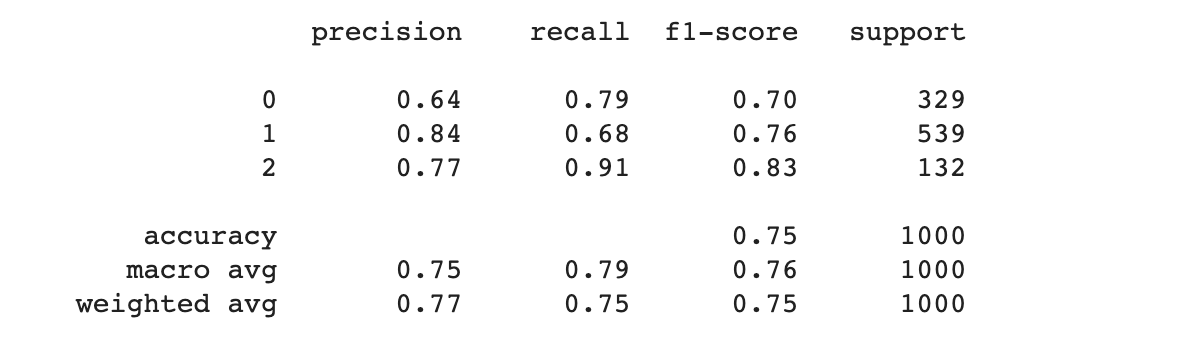

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, plot_confusion_matrix, ConfusionMatrixDisplay

In [ ]:
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Negatif',"Nötr",'Pozitif'])
disp.plot(cmap='Blues') 

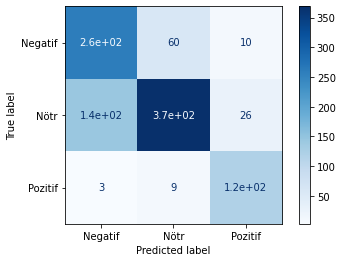

In [ ]:
# Saving the model and weight:

model.save_weights("drive/My Drive/bert/Sentiment_Analysis_adangrad_5e-5_075_600_karışık_notrsuz10000poz150_weight.h5")
model.save("drive/My Drive/bert/modelSentiment_Analysis_adangrad_5e-5_075_600_karışık_notrsuz10000poz150_weight.h5")

# <font color='red'> Step 5: Final Model Predictions on 150k Dataset</font>

In [ ]:
# Reading the 150K test csv file: Preprocessed, Cleaned, NER'ed, Untagged, Sampled by the county ratios.

df_final=pd.read_csv("drive/My Drive/SON DATA/FINAL-TAGSIZ(test).csv")

In [ ]:
# Deleting unnecessary columns:

df_final.drop(labels=["X_IBB_NEIGHBOURHOOD","Unnamed: 0","lang","preProcessing"], axis=1,inplace=True)

In [ ]:
df_final.drop(labels=["ORG_TICKET_ID","SR_AREA","SR_SUBTYPE_CD","clean_new"], axis=1,inplace=True)

In [ ]:
df_final.to_csv("drive/My Drive/Colab Notebooks/SONTESTDATA_etiketsiz_150_2.csv")

In [ ]:
import csv
import json
def csv_to_json(csvFilePath, jsonFilePath):
    jsonArray = []
      
    # Read csv file.
    with open(csvFilePath, encoding='utf-8') as csvf: 
        # Load csv file data using csv library's dictionary reader.
        csvReader = csv.DictReader(csvf) 

        # Convert each csv row into python dict.
        for row in csvReader: 
            # Add this python dict to json array.
            jsonArray.append(row)
  
    # Convert python jsonArray to JSON String and write to file.
    with open(jsonFilePath, 'w', encoding='utf-8') as jsonf: 
        jsonString = json.dumps(jsonArray, indent=4)
        jsonf.write(jsonString)
          
csvFilePath = r"drive/My Drive/Colab Notebooks/SONTESTDATA_etiketsiz_150_2.csv"
jsonFilePath = r"drive/My Drive/Colab Notebooks/SONTESTDATA_etiketsiz_150_2.json"
csv_to_json(csvFilePath, jsonFilePath)

In [ ]:
final_test_path= "drive/My Drive/Colab Notebooks/SONTESTDATA_etiketsiz_150_2.json"

In [ ]:
with open(final_test_path, 'r') as f:
    final_test = json.load(f)

In [ ]:
def data_prep_2(dataset):
    X = []

    for element in tqdm(dataset):
        X.append(feature_extraction(element['clean_ner']))
    return np.array(X) 

X_test = data_prep_2(final_test)

Loading the best performing model and its weights to prediction on the final 150K test data.

In [ ]:
model=load_model("drive/My Drive/bert/modelSentiment_Analysis_adangrad_5e-5_075_600_karışık_notrsuz10000poz150_weight.h5")

In [ ]:
model.load_weights("drive/My Drive/bert/Sentiment_Analysis_adangrad_5e-5_075_600_karışık_notrsuz10000poz150_weight.h5")

In [ ]:
model.summary()

In [ ]:
y_pred= np.argmax(model.predict(X_test), 1) #predictions

In [ ]:
df_final["duygu"]= y_pred #predictions are added into the dataframe as new column named "duygu"

In [ ]:
df_final["duygu"].value_counts()

In [ ]:
df_final

In [ ]:
#saving predicted test data with it's predictions for using in daya visualizing phase
df_final.to_csv('drive/My Drive/NLP/Duygu Haritasi Grubu/Tüm notebooklar/DATA(CSV+JSON)/150test_etiketli_079.csv')

# <font color='red'> Step 6: Visualizing \& Mapping Findings </font>

## <font color='blue'> Visualizing Some Findings </font>

In [ ]:
from collections import Counter
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
# Plot word count distribution for both positive and negative sentiments:

x = df_final['totalwords'][df_final["duygu"] == 2] #positive
y = df_final['totalwords'][df_final["duygu"] == 0] #negative
z = df_final['totalwords'][df_final["duygu"] == 1] #neutral
plt.figure(figsize=(12,6))
plt.xlim(0,60)
plt.xticks(np.arange(5, 65, 5.0))
plt.title('Word Count Distribution for Each Sentiment')
plt.xlabel('word count')
plt.ylabel('frequency')
g = plt.hist([x, y, z], color=['g',"r",'y'], alpha=0.6, label=['pozitif','negatif', "notr"])
plt.legend(loc='upper right')

In [ ]:
# Plot word count distribution for both positive and negative sentiments:

x = df_final['totalwords'][df_final["duygu"] == 2] # positive
y = df_final['totalwords'][df_final["duygu"] == 0] # negative
plt.figure(figsize=(12,6))
plt.xlim(0,60)
plt.xticks(np.arange(5, 65, 5.0))
plt.title('Word Count Distribution for both Positive and Negative Sentiments')
plt.xlabel('word count')
plt.ylabel('frequency')
g = plt.hist([x, y], color=['g',"r"], alpha=0.6, label=['pozitif','negatif'])
plt.legend(loc='upper right')

In [ ]:
# Get most common words in test dataset:
all_words = []
for line in list(df_final['clean_ner']):
    words = line.split()
    for word in words:
        all_words.append(word)
    
Counter(all_words).most_common(10)

In [ ]:
# Plot word frequency distribution of first few words:

plt.figure(figsize=(12,5))
plt.title('Top 25 most common words')
plt.xticks(fontsize=13, rotation=90)
fd = nltk.FreqDist(all_words)
fd.plot(25,cumulative=False)

# log-log plot:
word_counts = sorted(Counter(all_words).values(), reverse=True)
plt.figure(figsize=(12,5))
plt.loglog(word_counts, linestyle='-', linewidth=1.5)
plt.ylabel("Freq")
plt.xlabel("Word Rank")
plt.title('log-log plot of words frequency')

In [ ]:
# Plot histogram of tickets counts by county:

import seaborn as sns
sns.set_style("darkgrid")
x = df_final["X_IBB_COUNTY"].value_counts(1).head(20)
x.plot(kind='bar',figsize=(10,6),fontsize=13,color='steelblue')
plt.ylabel('% of Total Tickets', fontsize=13)

Firstly we found Turkey's all counties latitude and longitude CSV file from Kaggle. Then, we filtered İstanbul Counties latitude  and longitude from this file and adding those into df_final as new columns.

In [ ]:
ilce_geo= pd.read_csv("drive/My Drive/NLP/Duygu Haritasi Grubu/harita&veri görselleştirme/ilce.csv") 

# Turkey's all counties latitude and longitude.

In [ ]:
labels=["northeast_lat","northeast_lon","southwest_lat","southwest_lon"]
ilce_geo.drop(labels=labels,axis=1,inplace=True)

# Drop the unnecessary columns.

In [ ]:
ist_ilce = ['ADALAR', 'ARNAVUTKÖY', 'ATAŞEHİR', 'AVCILAR', 'BAĞCILAR', 'BAHÇELİEVLER', 'BAKIRKÖY', 'BAŞAKŞEHİR', 'BAYRAMPAŞA', 'BEŞİKTAŞ', 'BEYKOZ', 'BEYLİKDÜZÜ', 'BEYOĞLU', 'BÜYÜKÇEKMECE', 'ÇATALCA', 'ÇEKMEKÖY', 'ESENLER', 'ESENYURT', 'EYÜPSULTAN', 'FATİH', 'GAZİOSMANPAŞA', 'GÜNGÖREN', 'KADIKÖY', 'KAĞITHANE', 'KARTAL', 'KÜÇÜKÇEKMECE', 'MALTEPE', 'PENDİK', 'SANCAKTEPE', 'SARIYER', 'ŞİŞLİ', 'ŞİLE', 'SİLİVRİ', 'SULTANBEYLİ', 'SULTANGAZİ', 'TUZLA', 'ÜMRANİYE', 'ÜSKÜDAR', 'ZEYTİNBURNU']
boolean_series = ilce_geo["ilce_adi"].isin(ist_ilce)
filtered_df = ilce_geo[boolean_series]

print(filtered_df) 

# Filtered Istanbul Counties from the ilce_geo file except Eyüpsultan because it is missing in the open source Kaggle dataset.

In [ ]:
# Adding Eyüpsultan lat and lon into the df:

eyüpsultan= {"ilce_id":[34] , "ilce_adi":["EYÜPSULTAN"], "lat":[41.0551], "lon":[28.9346]}
eyüpdf=pd.DataFrame.from_dict(eyüpsultan)

In [ ]:
filtered_df=filtered_df.append(eyüpdf)

In [ ]:
label=["ilce_id" , "il_plaka"]
filtered_df.drop(labels=label, axis=1, inplace=True)

In [ ]:
filtered_df=filtered_df.rename(columns={"ilce_adi": "X_IBB_COUNTY"}) 

# Because we would like to merge this df with the df that we calculated sentiment scores in it,
# We need same column name for this.

In [ ]:
filtere_df=filtered_df.reset_index()

In [ ]:
filtered_df.to_csv (".../filtered_df.csv")

Calculating Sentiment Scores for each county in Istanbul:

In [ ]:
filtered_df = pd.read_csv(".../filtered_df.csv")

In [ ]:
df_score = filtered_df.groupby(['X_IBB_COUNTY'])['duygu'].value_counts().unstack().fillna(0.0).reset_index()

In [ ]:
df_score.rename(columns = {"X_IBB_COUNTY": "county", 0: "neg", 1: "neutral", 2: "pos"}, inplace = True)

In [ ]:
county_list = [16033, 296709, 422594, 436897, 592371, 226229, 269950, 737206, 469924, 246110,  365572, 226396, 176513, 257362, 446276, 957398, 405845, 396594, 487778,280299, 481983, 474514, 442415, 789633, 515021, 726481, 456861, 335298, 343318, 537488, 200215, 273608, 283657, 74975, 273658, 713803, 520771, 37904, 266793]
cl = pd.Series(county_list)

In [ ]:
df_score["skor"] = df_score["poz"] - df_score["neg"]
df_score["ilce_nufus"] = pl.values
df_score["kisi_basi_ticket"] = (df_score["notr"] + df_score["neg"] + df_score["poz"]) / df_score["ilce_nufus"]
df_score["kisi_basi_neg_ticket"] = df_score["neg"] / df_score["ilce_nufus"]
df_score["duygu_orani"] = (df_score["poz"] + df_score["neg"]) / (df_score["notr"] + df_score["neg"] + df_score["poz"]) 
df_score["neg_poz_orani"] = df_score["neg"] / df_score["poz"]

In [ ]:
df_score.to_csv(".../df_score.csv")

Merging the filtered_df with df_score because we will use this merged df for mapping.

In [ ]:
latlon_join = pd.merge(filtered_df,  
                      df_score,  
                      on ='X_IBB_COUNTY',  
                      how ='left')
latlon_join

In [ ]:
latlon_join.to_csv("/.../150ktest_latlon_score_079.csv")

## <font color='blue'> Interactive Mapping </font>

In [ ]:
import plotly.express as px
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
# Downloading latlot_join df:

df_sentimentlan=pd.read_csv("/.../150ktest_latlon_score_079.csv")

In [ ]:
# Deleting unnecessary columns:

df_sentimentlan.drop(labels=["Unnamed: 0.1"],axis=1,inplace=True)

In [ ]:
df_sentimentlan

In [ ]:
df=df_sentimentlan.set_index('X_IBB_COUNTY')

In [ ]:
# Plot histogram of tickets counts per person for each county:

sns.set_style("darkgrid")
x = df["kisi_basi_ticket"].sort_values(ascending=False).head(10) #top 10 counties in terms of the highest tickets counts per person
x.plot(kind='bar',figsize=(10,6),fontsize=13,color='steelblue')
plt.ylabel('Tickets per County', fontsize=13)

In [ ]:
# Color in the map represents the negativity/positivity ratio.
# Darker red circles are the most negative counties.
# Green circles are the most positive counties.
# Size in the map shows the negative ticket counts per person.
# Bigger circles are the highest negative ticket counts per person.

fig = px.scatter_mapbox(df_sentimentlan , lat="lat", lon="lon", hover_name="X_IBB_COUNTY", hover_data=["kisi_basi_neg_ticket","neg_poz_orani"], size="kisi_basi_neg_ticket", color="neg_poz_orani",color_continuous_scale=[(0,"green"),(0.06,"yellow"),(1,"red")],range_color=[0,17], zoom=9.5, height=600)
fig.update_layout(mapbox_style="open-street-map")
fig.update_layout(margin=dict(t=0, r=0, b=0, l=0))
fig.show()

In [ ]:
# Size and color in the map shows the ratio of (negative tickets + positive tickets) / (all tickets)
# If color warmer == more emotional tickets.
# If color colder == more neutral tickets. 

fig = px.scatter_mapbox(df_sentimentlan , lat="lat", lon="lon", hover_name="X_IBB_COUNTY", hover_data=["duygu_orani"], size="duygu_orani",size_max=15,color="duygu_orani",color_continuous_scale=px.colors.sequential.Turbo,color_continuous_midpoint =0.5,zoom=9.5, height=600)
fig.update_layout(mapbox_style="open-street-map")
fig.update_layout(margin=dict(t=0, r=0, b=0, l=0))
fig.show()

## <font color='blue'> Word Cloud </font>

In [ ]:
pip install jpype1
import seaborn as sns
import matplotlib
from matplotlib import pyplot as plt
pip install wordcloud
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

% matplotlib inline

from collections import Counter

In [ ]:
df_final = pd.read_csv('drive/My Drive/NLP/Duygu Haritasi Grubu/Tüm notebooklar/DATA(CSV+JSON)/150test_etiketli_079.csv')

In [ ]:
df_final = df_final.astype(str)

**General:**

In [ ]:
county = df.groupby("X_IBB_COUNTY")

In [ ]:
p = Counter(" ".join(df["clean_ner"]).split()).most_common(150)
rslt = pd.DataFrame(p, columns=['Word', 'Frequency'])
sw = set(rslt['Word'])

In [ ]:
sw1 = {'ad', 'al', 'alan', 'adres', 'alma', 'alın', 'an', 'alt', 'ama', 'ancak', 'ara', 'arka', 'arz', 'ay', 'aç', 'ba', 'bak', 'bekle',\
       'belediye', 'belir', 'ben', 'bil', 'bin', 'bir', 'bırak', 'bugün', 'bulun', 'bura', 'caddesi', 'devam', 'değil', 'diğer',\
       'dile', 'dolayı', 'doğru', 'durum', 'et', 'fakat', 'fazla', 'gel', 'geç', 'geçen','gelme', 'gerek', 'geri', 'geç', 'geçen' \
       'gir', 'git', 'gün', 'hak', 'hala', 'hafta', 'iki', 'iste', 'iyi', 'iç', 'içeri', 'işlem', 'kadar', 'kal',\
       'ke', 'kendi', 'kişi', 'kon', 'konu', 'kullan', 'lütfen', 'mahallesi', 'merhaba', 'mi', 'ol', 'olma', 'oluş', 'ora', 'otur', \
       'rağmen', 'sağla', 'se', 'site', 'sokak', 'son', 'sonra', 'sonuç', 'söyle', 'şua', 'şekil', 'tane', 'taraf', 'tarafından', 'tarih', 'tekrar', \
       'uygula', 'üst', 'var', 'ver', 'yan', 'yar', 'yap', 'yapma', 'yaş', 'yaşa', 'yaz', 'yeni', 'yer', 'yok', 'yol', 'yolcu', \
       'yön', 'yüz', 'zaman', 'zor', 'çık', 'ön', 'önce', 'üzeri', 'tek', 'gelma', 'ilk', 'başla', 'verme', 'aynı'\
       'kes', 'ayak', 'ait', 'ayrıca', 'yıl', 'ilet', 'beri', 'sat', 'mevcut', 'başka', 'gerekli', 'nisa', 'koy', 'sahip', \
       'çek', 'bulunma', 'kes', 'ilçe', 'dol', 'kod', 'kalk', 'kısım', 'mahalle', 'cadde', 'art', 'isim', 'yüklem', 'av', \
       'oku', 'istanbul', 'ibb', 'numara', 'numaralı', 'ey', 'herhangi', 'insan', 'kısa', 'yönlen', 'ye', 'sadece', 'tam', 'genel',\
       'sor', 'böyle', 'şöyle', 'tc', 'alakalı', 'karşı', 'tl', 'nokta', 'dakika', 'aralık', 'sürekli'}

text = " ".join(word for word in df["clean_ner"])

wordcloud = WordCloud(width = 1200, height = 800, 
                      random_state=1, 
                      background_color ='white', 
                      stopwords = sw1,
                      collocations= False,
                      min_font_size = 15).generate(text)

plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

wordcloud.to_file(".../genel.png")

**Adalar:**

In [ ]:
adalar = ilce_group.get_group("ADALAR")

In [ ]:
swadalar = {'ad', 'al', 'alan', 'adres', 'alma', 'alın', 'an', 'alt', 'ama', 'ancak', 'ara', 'arka', 'arz', 'ay', 'aç', 'ba', 'bak', 'bekle',\
       'belediye', 'belir', 'ben', 'bil', 'bin', 'bir', 'bırak', 'bugün', 'bulun', 'bura', 'caddesi', 'devam', 'değil', 'diğer',\
       'dile', 'dolayı', 'doğru', 'durum', 'et', 'fakat', 'fazla', 'gel', 'geç', 'geçen','gelme', 'gerek', 'geri', 'geç', 'geçen' \
       'gir', 'git', 'gün', 'hak', 'hala', 'hafta', 'iki', 'iste', 'iyi', 'iç', 'içeri', 'işlem', 'kadar', 'kal',\
       'ke', 'kendi', 'kişi', 'kon', 'konu', 'kullan', 'lütfen', 'mahallesi', 'merhaba', 'mi', 'ol', 'olma', 'oluş', 'ora', 'otur', \
       'rağmen', 'sağla', 'se', 'site', 'sokak', 'son', 'sonra', 'sonuç', 'söyle', 'şua', 'şekil', 'tane', 'taraf', 'tarafından', 'tarih', 'tekrar', \
       'uygula', 'üst', 'var', 'ver', 'yan', 'yar', 'yap', 'yapma', 'yaş', 'yaşa', 'yaz', 'yeni', 'yer', 'yok', 'yol', 'yolcu', \
       'yön', 'yüz', 'zaman', 'zor', 'çık', 'ön', 'önce', 'üzeri', 'tek', 'gelma', 'ilk', 'başla', 'verme', 'aynı'\
       'kes', 'ayak', 'ait', 'ayrıca', 'yıl', 'ilet', 'beri', 'sat', 'mevcut', 'başka', 'gerekli', 'nisa', 'koy', 'sahip', \
       'çek', 'bulunma', 'kes', 'ilçe', 'dol', 'kod', 'kalk', 'kısım', 'mahalle', 'cadde', 'art', 'isim', 'yüklem', 'av', \
       'oku', 'istanbul', 'ibb', 'numara', 'numaralı', 'ey', 'herhangi', 'insan', 'kısa', 'yönlen', 'ye', 'sadece', 'tam', 'genel',\
       'sor', 'böyle', 'şöyle', 'tc', 'alakalı', 'karşı', 'ada', 'adalar', 'yat', 'buda', 'tl', 'tel', 'gör', \
       'nokta', 'sun', 'uyma', 'büyükayı', 'el', 'sivri', 'biz', 'neden', 'tandem', 'ne', 'da', 'unut', 'çal', \
       'de', 'hal', 'göster', 'bu', 'mail', 'in'}

text = " ".join(word for word in adalar["clean_ner"])

wordcloud_adalar = WordCloud(width = 1200, height = 800, 
                      random_state=1, 
                      background_color ='white', 
                      stopwords = swadalar,
                      collocations= False,
                      min_font_size = 20).generate(text)

plt.imshow(wordcloud_adalar, interpolation = 'bilinear')
plt.axis("off")
plt.show()

wordcloud_adalar.to_file(".../adalar.png")

**Besiktas:**

In [ ]:
besiktas = ilce_group.get_group("BEŞİKTAŞ")

In [ ]:
swbesiktas = {'ad', 'al', 'alan', 'adres', 'alma', 'alın', 'an', 'alt', 'ama', 'ancak', 'ara', 'arka', 'arz', 'ay', 'aç', 'ba', 'bak', 'bekle',\
       'belediye', 'belir', 'ben', 'bil', 'bin', 'bir', 'bırak', 'bugün', 'bulun', 'bura', 'caddesi', 'devam', 'değil', 'diğer',\
       'dile', 'dolayı', 'doğru', 'durum', 'et', 'fakat', 'fazla', 'gel', 'geç', 'geçen','gelme', 'gerek', 'geri', 'geç', 'geçen' \
       'gir', 'git', 'gün', 'hak', 'hala', 'hafta', 'iki', 'iste', 'iyi', 'iç', 'içeri', 'işlem', 'kadar', 'kal',\
       'ke', 'kendi', 'kişi', 'kon', 'konu', 'kullan', 'lütfen', 'mahallesi', 'merhaba', 'mi', 'ol', 'olma', 'oluş', 'ora', 'otur', \
       'rağmen', 'sağla', 'se', 'site', 'sokak', 'son', 'sonra', 'sonuç', 'söyle', 'şua', 'şekil', 'tane', 'taraf', 'tarafından', 'tarih', 'tekrar', \
       'uygula', 'üst', 'var', 'ver', 'yan', 'yar', 'yap', 'yapma', 'yaş', 'yaşa', 'yaz', 'yeni', 'yer', 'yok', 'yol', 'yolcu', \
       'yön', 'yüz', 'zaman', 'zor', 'çık', 'ön', 'önce', 'üzeri', 'tek', 'gelma', 'ilk', 'başla', 'verme', 'aynı'\
       'kes', 'ayak', 'ait', 'ayrıca', 'yıl', 'ilet', 'beri', 'sat', 'mevcut', 'başka', 'gerekli', 'nisa', 'koy', 'sahip', \
       'çek', 'bulunma', 'kes', 'ilçe', 'dol', 'kod', 'kalk', 'kısım', 'mahalle', 'cadde', 'art', 'isim', 'yüklem', 'av', \
       'oku', 'istanbul', 'ibb', 'numara', 'numaralı', 'ey', 'herhangi', 'insan', 'kısa', 'yönlen', 'ye', 'sadece', 'tam', 'genel',\
       'sor', 'böyle', 'şöyle', 'tc', 'alakalı', 'karşı', 'ada', 'adalar', 'yat', 'buda', 'arnavutköy', 'kalklı', 'bollı', 'beşiktaş',\
       'gözük', 'plaka', 'plakalı', 'tl', 'te', 'eti', 'etme', 'ispari', 'yad', 'dt', 'etma', 'biz', 'siz', 'da', \
       'de', 'ne', 'beyaz', 'verma', 'orta', 'ulu', 'talep', 'şikayet'}

text = " ".join(word for word in besiktas["clean_ner"])

wordcloud_besiktas = WordCloud(width = 1200, height = 800, 
                      random_state=1, 
                      background_color ='white', 
                      stopwords = swbesiktas,
                      collocations= False,
                      min_font_size = 15).generate(text)

plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis("off")
plt.show()

wordcloud_besiktas.to_file(".../besiktas.png")

**Sultanbeyli:**

In [ ]:
sultanbeyli = ilce_group.get_group("SULTANBEYLİ")

In [ ]:
swsultanbeyli = {'ad', 'al', 'alan', 'adres', 'alma', 'alın', 'an', 'alt', 'ama', 'ancak', 'ara', 'arka', 'arz', 'ay', 'aç', 'ba', 'bak', 'bekle',\
       'belediye', 'belir', 'ben', 'bil', 'bin', 'bir', 'bırak', 'bugün', 'bulun', 'bura', 'caddesi', 'devam', 'değil', 'diğer',\
       'dile', 'dolayı', 'doğru', 'durum', 'et', 'fakat', 'fazla', 'gel', 'geç', 'geçen','gelme', 'gerek', 'geri', 'geç', 'geçen' \
       'gir', 'git', 'gün', 'hak', 'hala', 'hafta', 'iki', 'iste', 'iyi', 'iç', 'içeri', 'işlem', 'kadar', 'kal',\
       'ke', 'kendi', 'kişi', 'kon', 'konu', 'kullan', 'lütfen', 'mahallesi', 'merhaba', 'mi', 'ol', 'olma', 'oluş', 'ora', 'otur', \
       'rağmen', 'sağla', 'se', 'site', 'sokak', 'son', 'sonra', 'sonuç', 'söyle', 'şua', 'şekil', 'tane', 'taraf', 'tarafından', 'tarih', 'tekrar', \
       'uygula', 'üst', 'var', 'ver', 'yan', 'yar', 'yap', 'yapma', 'yaş', 'yaşa', 'yaz', 'yeni', 'yer', 'yok', 'yol', 'yolcu', \
       'yön', 'yüz', 'zaman', 'zor', 'çık', 'ön', 'önce', 'üzeri', 'tek', 'gelma', 'ilk', 'başla', 'verme', 'aynı'\
       'kes', 'ayak', 'ait', 'ayrıca', 'yıl', 'ilet', 'beri', 'sat', 'mevcut', 'başka', 'gerekli', 'nisa', 'koy', 'sahip', \
       'çek', 'bulunma', 'kes', 'ilçe', 'dol', 'kod', 'kalk', 'kısım', 'mahalle', 'cadde', 'art', 'isim', 'yüklem', 'av', \
       'oku', 'istanbul', 'ibb', 'numara', 'numaralı', 'ey', 'herhangi', 'insan', 'kısa', 'yönlen', 'ye', 'sadece', 'tam', 'genel',\
       'sor', 'böyle', 'şöyle', 'tc', 'alakalı', 'karşı', 'ada', 'adalar', 'yat', 'buda', 'arnavutköy', 'kalklı', 'bollı', 'beşiktaş',\
       'gözük', 'plaka', 'plakalı', 'tl', 'sultanbeyli', 'talep', 'şikayet', 'ne', 'etme', 'sürekli', 'km', 'da', \
       'de', 'biz', 'siz', 'başar', 'kod', 'kodlu', 'yaklaşık', 'mb', 'uza', 'ilgili', 'aynı', 'etma', 'has', \
       'mu', 'ya','ödema', 've', 'yas'}

text = " ".join(word for word in sultanbeyli["clean_ner"])

wordcloud_sultanbeyli = WordCloud(width = 1200, height = 800, 
                      random_state=1, 
                      background_color ='white', 
                      stopwords = swsultanbeyli,
                      collocations= False,
                      min_font_size = 15).generate(text)

plt.imshow(wordcloud_sultanbeyli, interpolation = 'bilinear')
plt.axis("off")
plt.show()

wordcloud_sultanbeyli.to_file(".../sultanbeyli.png")

**Positive Tickets:**

In [ ]:
duygu_group = df.groupby(["duygu"])

In [ ]:
poz = duygu_group.get_group("2")

In [ ]:
swpoz = {'ad', 'al', 'alan', 'adres', 'alma', 'alın', 'an', 'alt', 'ama', 'ancak', 'ara', 'arka', 'arz', 'ay', 'aç', 'ba', 'bak', 'bekle',\
       'belediye', 'belir', 'ben', 'bil', 'bin', 'bir', 'bırak', 'bugün', 'bulun', 'bura', 'caddesi', 'devam', 'değil', 'diğer',\
       'dile', 'dolayı', 'doğru', 'durum', 'et', 'fakat', 'fazla', 'gel', 'geç', 'geçen','gelme', 'gerek', 'geri', 'geç', 'geçen' \
       'gir', 'git', 'gün', 'hak', 'hala', 'hafta', 'iki', 'iste', 'iyi', 'iç', 'içeri', 'işlem', 'kadar', 'kal',\
       'ke', 'kendi', 'kişi', 'kon', 'konu', 'kullan', 'lütfen', 'mahallesi', 'merhaba', 'mi', 'ol', 'olma', 'oluş', 'ora', 'otur', \
       'rağmen', 'sağla', 'se', 'site', 'sokak', 'son', 'sonra', 'sonuç', 'söyle', 'şua', 'şekil', 'tane', 'taraf', 'tarafından', 'tarih', 'tekrar', \
       'uygula', 'üst', 'var', 'ver', 'yan', 'yar', 'yap', 'yapma', 'yaş', 'yaşa', 'yaz', 'yeni', 'yer', 'yok', 'yol', 'yolcu', \
       'yön', 'yüz', 'zaman', 'zor', 'çık', 'ön', 'önce', 'üzeri', 'tek', 'gelma', 'ilk', 'başla', 'verme', 'aynı'\
       'kes', 'ayak', 'ait', 'ayrıca', 'yıl', 'ilet', 'beri', 'sat', 'mevcut', 'başka', 'gerekli', 'nisa', 'koy', 'sahip', \
       'çek', 'bulunma', 'kes', 'ilçe', 'dol', 'kod', 'kalk', 'kısım', 'mahalle', 'cadde', 'art', 'isim', 'yüklem', 'av', \
       'oku', 'istanbul', 'ibb', 'numara', 'numaralı', 'ey', 'herhangi', 'insan', 'kısa', 'yönlen', 'ye', 'sadece', 'tam', 'genel',\
       'sor', 'böyle', 'şöyle', 'tc', 'alakalı', 'karşı', 'tl', 'nokta', 'dakika', 'aralık', 'sürekli', 'nebahat', 'link', \
       'alo', 'sun', 'bey', 'gir', 'system', 'maç'}

text = " ".join(word for word in poz["clean_ner"])

wordcloud_poz = WordCloud(width = 1200, height = 800, 
                      random_state=1, 
                      background_color ='white', 
                      stopwords = swpoz,
                      collocations= False,
                      max_words = 100,
                      min_font_size = 20).generate(text)

plt.imshow(wordcloud_poz, interpolation = 'bilinear')
plt.axis("off")
plt.show()

wordcloud_poz.to_file(".../poz.png")

**Negative Tickets:**

In [ ]:
neg = duygu_group.get_group("0")

In [ ]:
swneg = {'ad', 'al', 'alan', 'adres', 'alma', 'alın', 'an', 'alt', 'ama', 'ancak', 'ara', 'arka', 'arz', 'ay', 'aç', 'ba', 'bak', 'bekle',\
       'belediye', 'belir', 'ben', 'bil', 'bin', 'bir', 'bırak', 'bugün', 'bulun', 'bura', 'caddesi', 'devam', 'değil', 'diğer',\
       'dile', 'dolayı', 'doğru', 'durum', 'et', 'fakat', 'fazla', 'gel', 'geç', 'geçen','gelme', 'gerek', 'geri', 'geç', 'geçen' \
       'gir', 'git', 'gün', 'hak', 'hala', 'hafta', 'iki', 'iste', 'iyi', 'iç', 'içeri', 'işlem', 'kadar', 'kal',\
       'ke', 'kendi', 'kişi', 'kon', 'konu', 'kullan', 'lütfen', 'mahallesi', 'merhaba', 'mi', 'ol', 'olma', 'oluş', 'ora', 'otur', \
       'rağmen', 'sağla', 'se', 'site', 'sokak', 'son', 'sonra', 'sonuç', 'söyle', 'şua', 'şekil', 'tane', 'taraf', 'tarafından', 'tarih', 'tekrar', \
       'uygula', 'üst', 'var', 'ver', 'yan', 'yar', 'yap', 'yapma', 'yaş', 'yaşa', 'yaz', 'yeni', 'yer', 'yok', 'yol', 'yolcu', \
       'yön', 'yüz', 'zaman', 'zor', 'çık', 'ön', 'önce', 'üzeri', 'tek', 'gelma', 'ilk', 'başla', 'verme', 'aynı'\
       'kes', 'ayak', 'ait', 'ayrıca', 'yıl', 'ilet', 'beri', 'sat', 'mevcut', 'başka', 'gerekli', 'nisa', 'koy', 'sahip', \
       'çek', 'bulunma', 'kes', 'ilçe', 'dol', 'kod', 'kalk', 'kısım', 'mahalle', 'cadde', 'art', 'isim', 'yüklem', 'av', \
       'oku', 'istanbul', 'ibb', 'numara', 'numaralı', 'ey', 'herhangi', 'insan', 'kısa', 'yönlen', 'ye', 'sadece', 'tam', 'genel',\
       'sor', 'böyle', 'şöyle', 'tc', 'alakalı', 'karşı', 'ada', 'adalar', 'yat', 'buda', 'arnavutköy', 'kalklı', 'bollı', \
       'tl'}

text = " ".join(word for word in neg["clean_ner"])

wordcloud_neg = WordCloud(width = 1200, height = 800, 
                      random_state=1, 
                      background_color ='white', 
                      stopwords = swneg,
                      collocations= False,
                      min_font_size = 15).generate(text)

plt.imshow(wordcloud_neg, interpolation = 'bilinear')
plt.axis("off")
plt.show()

wordcloud_neg.to_file(".../neg.png")